In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

2023-11-09 19:27:33.330601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 19:27:34.279328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [2]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/shape/train_shape_5_9times.npy'
train_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/train/npy/lc/train_lc_1_to_9.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
print('train_lc.shape =',train_lc.shape)
print('train_shape.shape = ',train_shape.shape)
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/shape/vald_shape_1_9times.npy'
vald_lc_dir = '/scratch/abraham/Documents/mega_git/mega/data/vald/npy/lc/vald_lc_1_to_9.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
print('vald_lc.shape =',vald_lc.shape)
print('vald_shape.shape = ',vald_shape.shape)
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

train_lc.shape = (1189224, 100)
train_shape.shape =  (1189224, 38, 38)
Train Set: No. of LC = No. of shapes
vald_lc.shape = (9000, 100)
vald_shape.shape =  (9000, 38, 38)
Vald Set: No. of LC = No. of shapes


In [3]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [4]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [5]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (1189224, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


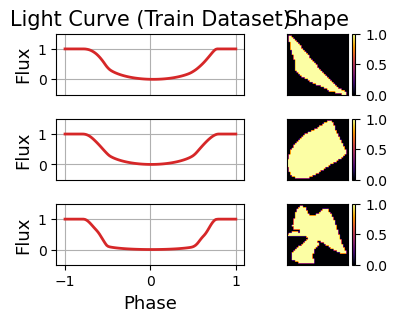

In [6]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

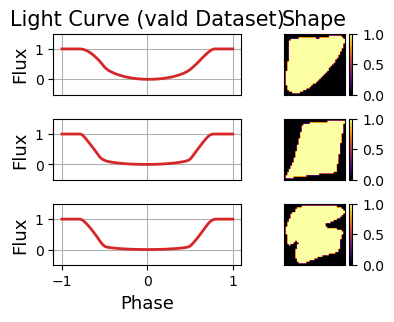

In [7]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (vald Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = np.random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [8]:
# Array of number of datapoints to sample
rng = np.random.default_rng()
train_sample_Ndatapoints = rng.integers(20,60,len(train_lc_scaled_append))
vald_sample_Ndatapoints = rng.integers(20,60,len(vald_lc_scaled_append))

print('train_sample_Ndatapoints[0:10] = ',train_sample_Ndatapoints[0:10])
print('vald_sample_Ndatapoints[0:10] = ',vald_sample_Ndatapoints[0:10])

train_sample_Ndatapoints[0:10] =  [44 44 37 20 57 46 49 22 32 23]
vald_sample_Ndatapoints[0:10] =  [41 38 32 28 40 49 32 58 37 35]


In [9]:
# # (1) Interpolate Train light curve and 
# # (2) sample at different datapoints

# train_lc_scaled_interpol = np.zeros((len(train_lc_scaled_append),len(train_lc_scaled_append[0])))
# print('train_lc_scaled_interpol.shape = ',train_lc_scaled_interpol.shape)


# for iteration in np.arange(len(train_lc_scaled_interpol)):
#     ## 1. Select x number of datapoints
#     # Original data with 120 elements
#     original_x = np.linspace(-1, 1, num=len(train_lc_scaled_append[iteration]))
#     original_y = train_lc_scaled_append[iteration]  

#     # Create a quadratic interpolation function
#     f = interp1d(original_x, original_y, kind='quadratic')

#     # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
#     x_interpolation = np.linspace(-1, 1, num=train_sample_Ndatapoints[iteration])

#     # Perform the interpolation
#     y_interpolated = f(x_interpolation)
    
#     ## 2. Interpolate back to 120
#     original_x = np.linspace(-1, 1, num=len(y_interpolated))
#     original_y = y_interpolated  

#     # Create a quadratic interpolation function
#     f = interp1d(original_x, original_y, kind='quadratic')

#     # Define the range of x-values for the interpolation with 120 elements
#     x_interpolation = np.linspace(-1, 1, num=120)

#     # Perform the interpolation
#     y_interpolated = f(x_interpolation)


#     train_lc_scaled_interpol[iteration] = y_interpolated

In [10]:
# (1) Interpolate Train light curve and 
# (2) sample at different datapoints
def sample_interpolate_simul_lc(simulated_lc):
    simulated_lc_interpol = np.zeros((len(simulated_lc),len(simulated_lc[0])))
    print('simulated_lc_interpol.shape = ',simulated_lc_interpol.shape)


    for iteration in np.arange(len(simulated_lc_interpol)):
        ## 1. Select x number of datapoints
        # Original data with 120 elements
        original_x = np.linspace(-1, 1, num=len(simulated_lc[iteration]))
        original_y = simulated_lc[iteration]  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 'train_sample_Ndatapoints elements
        x_interpolation = np.linspace(-1, 1, num=train_sample_Ndatapoints[iteration])

        # Perform the interpolation
        y_interpolated = f(x_interpolation)
        
        ## 2. Interpolate back to 120
        original_x = np.linspace(-1, 1, num=len(y_interpolated))
        original_y = y_interpolated  

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='quadratic')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=len(simulated_lc[0]))

        # Perform the interpolation
        y_interpolated = f(x_interpolation)


        simulated_lc_interpol[iteration] = y_interpolated
    return(simulated_lc_interpol)
    
train_lc_scaled_interpol = sample_interpolate_simul_lc(simulated_lc=train_lc_scaled_append)
vald_lc_scaled_interpol = sample_interpolate_simul_lc(simulated_lc=vald_lc_scaled_append)

simulated_lc_interpol.shape =  (1189224, 120)
simulated_lc_interpol.shape =  (9000, 120)


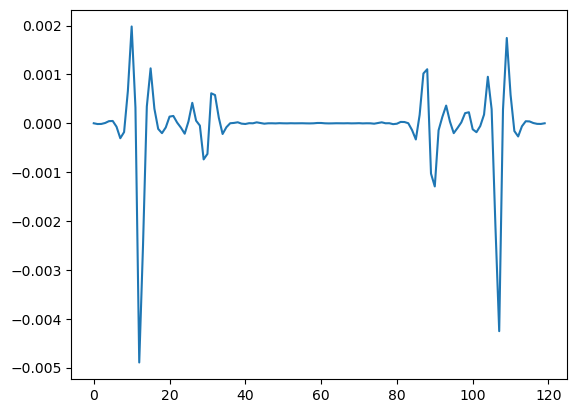

In [11]:
plt.plot(train_lc_scaled_interpol[0]-train_lc_scaled_append[0])
plt.show()

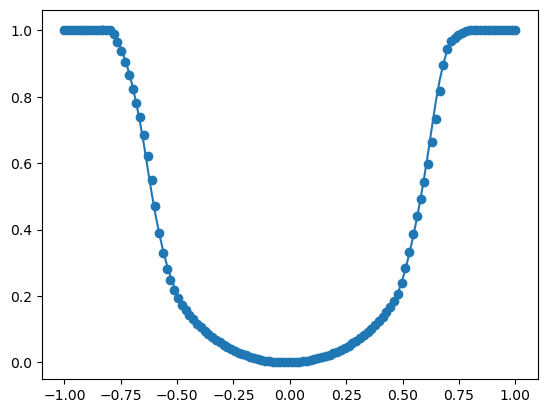

In [12]:
plt.plot(np.linspace(-1,1,len(train_lc_scaled_interpol[5000])),train_lc_scaled_interpol[5000])
plt.scatter(np.linspace(-1,1,len(train_lc_scaled_append[5000])),train_lc_scaled_append[5000])
plt.show()

# Old

In [13]:
# def bin_data(x,y,blength):
#     """ Takes 2 arrays x and y and bins them into groups of blength.
#         blength must be odd, if not it's made odd. 
#         Inputs:     x, y:                   1D lists or numpy arrays
#         Outputs:	xout, yout, yerrout:    1D numpy arrays
#     """

#     # convert to arrays if necessary
#     x = array(x)
#     y = array(y)

#     # check oddness
#     if blength % 2 == 0: 
#         blength += 1

#     nobins = len(x)/blength
#     xmid = (blength-1)/2
#     xbinmax = nobins*blength - xmid
#     xout,yout,yerrout = [],[],[]
#     for i in range(int(xmid),int(xbinmax),int(blength)):
#         xmin = i-int(xmid)
#         xmax = i+int(xmid)
#         xout.append(sum(x[xmin:xmax+1])/blength)
#         yout.append(sum(y[xmin:xmax+1])/blength)
#         yerrout.append(std(y[xmin:xmax+1]))
        
#     return array(xout),array(yout),array(yerrout)

# for i in np.arange(0,121,1):
#     ph_new, y_new,*_ = bin_data(ph,vald_lc_scaled_append[0],blength=i)
# # plt.plot(ph,vald_lc_scaled_append[0])
# # plt.scatter(ph_new,y_new)
# # plt.show()
#     print("i = ",i,"- len(y_new) = ",len(y_new))
# test = np.arange(0,120,1)
# i = 
# random_generator = np.random.default_rng()
# bin_step_size_train = random_generator.uniform(50,500,len(train_lc_scaled_append))

# print('test = ',test)
# print('test = ',test[::int(len(test)/30)])
# print('test = ',len(test[::10]))
# print('test = ',len(test[::9]))